In [1]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"

from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

jax.config.update("jax_enable_x64", True)

#### Loading Files

In [2]:
import pandas as pd

image_data = pd.read_csv('statistical_analysis/image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "Knots"]
print(image_data)

                Radius  Inclination  Position Angle  Distance  Knots
Name                                                                
hd145560_H_pol    85.3         43.9           221.5    120.44      7
hd146897_H_pol    85.0         84.0           293.9    131.50      9
ceant_H_pol       29.8         13.1           271.0     34.03      7
hd111520_H_pol    81.0         88.0           165.0    108.94      7
hd115600_H_pol    46.0         80.0            27.5    109.62      7
hd129590_H_pol    66.9         75.7           121.7    136.04      9
hd117214_H_pol    60.2         71.0           359.8    107.61     11
hd35841_H_pol     60.3         84.9           345.8    103.68      7
hd30447_H_pol     83.0         83.0            32.3     80.54      7
hd32297_H_pol     98.4         88.4            47.9    132.79     13
hd110058_H_pol    39.0         84.0           335.0    129.98      5
hd111161_H_pol    72.4         62.1           263.2    109.43      7
hd157587_H_pol    79.0         70.

### Processing Fits File

/home/mihirkondapalli/anaconda3/envs/jwst_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).
Filename: Fits/hd117214_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     496   ()      
  1  SCI           1 ImageHDU       138   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


Text(0.5, 1.0, 'Image from Fits File')

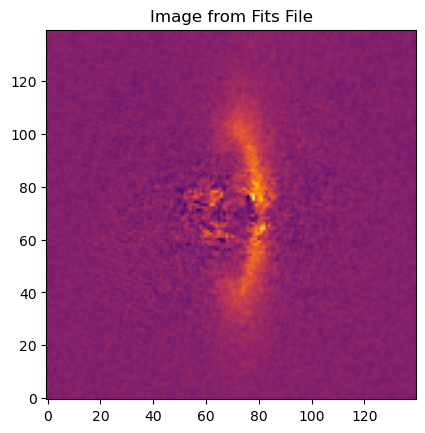

In [3]:
from statistical_analysis.old_optimize_framework import OptimizeUtils

name = "hd117214_H_pol"
fits_image_filepath = "Fits/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)
row = image_data.loc[name]

#Displays File Info
hdul.info()

# Gets Image
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")

## Getting Optimal Disk Fit

In [4]:
from statistical_analysis.old_optimize_framework import Optimizer, OptimizeUtils
from statistical_analysis.model_funcs import jax_model_spline
from statistical_analysis.likelihood_funcs import log_likelihood_pos_image
from utils.SLD_ojax import ScatteredLightDisk
from utils.old_SLD_utils import *

### Getting Optimal Fit

In [5]:

target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:])) #, outlier_pixels=[(57, 68)]))

In [6]:
# The values not from the csv file are a general starting guesses
init_params = np.array([5., -5., row["Radius"], row["Inclination"], row["Position Angle"], 70., 70.])

# 0: alpha_in, 1: alpha_out, 2: sma, 3: inclination, 4: position_angle, 5: x-center, 6: y-center
opt = Optimizer(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF,
                jax_model_spline, log_likelihood_pos_image, 0.01414, row["Distance"],
                knots = OptimizeUtils.get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])))

scaled_knots = OptimizeUtils.get_scaled_knots(opt, OptimizeUtils.get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])),
                                              row["Radius"], row["Inclination"], row["Position Angle"], target_image)

print(opt.log_likelihood(init_params, scaled_knots, target_image, err_map))

-51856.983905252666


Text(0.5, 1.0, 'Initial Guess, Log-Likelihood: -51856.983905252666')

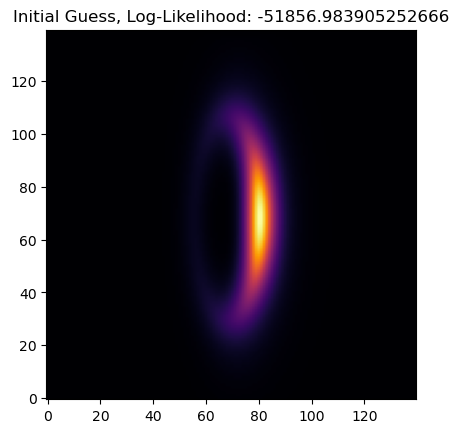

In [7]:
plt.imshow(opt.model(init_params, scaled_knots), origin='lower', cmap='inferno')
plt.title("Initial Guess, Log-Likelihood: " + str(opt.log_likelihood(init_params, scaled_knots, target_image, err_map)))

In [8]:
# Running optimization method
opt_disk_params, opt_spf_params = opt.scipy_optimize(init_params, scaled_knots, target_image, err_map, disp_soln=True)
optimal_image = opt.model(opt_disk_params, opt_spf_params)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 46333.61104176981
        x: [ 1.189e+01 -2.702e+00 ...  8.083e-04  1.735e-03]
      nit: 56
      jac: [ 0.000e+00  2.930e-03 ... -4.395e-02 -1.875e-01]
 hess_inv: [[ 2.983e+00 -5.937e-02 ... -2.440e-05  5.284e-04]
            [-5.937e-02  4.782e-03 ...  1.851e-06 -2.268e-05]
            ...
            [-2.440e-05  1.851e-06 ...  1.329e-08 -2.077e-08]
            [ 5.284e-04 -2.268e-05 ... -2.077e-08  1.972e-07]]
     nfev: 2908
     njev: 153


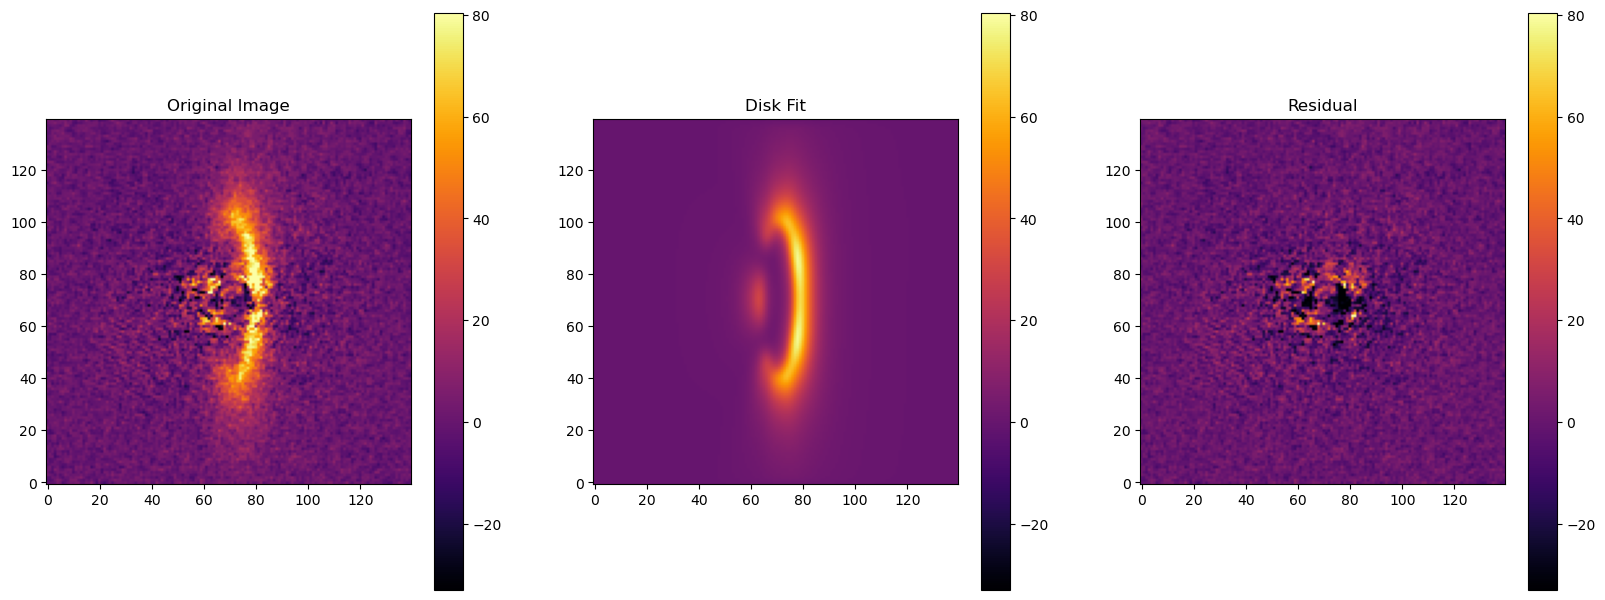

In [9]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno')
axes[1].set_title("Disk Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

#### Creating New Model/Likelihood/Optimization Functions within OptimizationFramework

In [10]:
# Can define new model functions in model_funcs.py
# Have to make separate model functions for spline spfs and non spline spfs, this is because spline spfs use knots which others don't use, since
# everything is in jax, adding if statements to the method would be inefficient
# Can customize the rest of the method as desired, you can fill in a lot of other default keyword parameters in the distribution/other classes by adding
# to the disk and spf arrays

# Can define new log-likelihood/likelihood functions in likelihood_funcs.py
# These are simple and do not depend on all the parameters the model does, it just takes the image from the model function and compared it to the target
# image using the error map
# The parameters should not change for any additional likelihood methods, just the math inside

# New optimization functions should be added to the Optimizer class, currently there is one for scipy optimize

## Running MCMC

In [11]:
# For MCMC, spline values are log scaled, they are passed in as log(spf_params) and are exponated in the lambda expression, this evens out the markov chains
# helping MCMC work better

CENT_BOUNDS = np.array([np.array([65, 65]), np.array([75, 75])])
DISK_BOUNDS = np.array([np.array([0.1, -15, 0, 0, 0]), np.array([15, -0.1, 150, 180, 400])])
SPLINE_BOUNDS = np.array([1e-8 * np.ones(jnp.size(opt_spf_params)), 0.1 * np.ones(jnp.size(opt_spf_params))])
BOUNDS = np.array([np.concatenate([DISK_BOUNDS[0], CENT_BOUNDS[0], np.log(SPLINE_BOUNDS[0])]),
                    np.concatenate([DISK_BOUNDS[1], CENT_BOUNDS[1], np.log(SPLINE_BOUNDS[1])])])

mc_model = opt.mcmc(opt_disk_params, opt_spf_params, target_image, err_map, BOUNDS, nwalkers=100, niter=100, burns=20)

Running burn-in...


100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


Running production...


100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


In [12]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
mc_disk_params = mc_soln[0:jnp.size(opt_disk_params)]
mc_spf_params = jnp.exp(mc_soln[jnp.size(opt_disk_params):])
img = opt.model(mc_disk_params, mc_spf_params)

Text(0.5, 1.0, 'Pre MCMC')

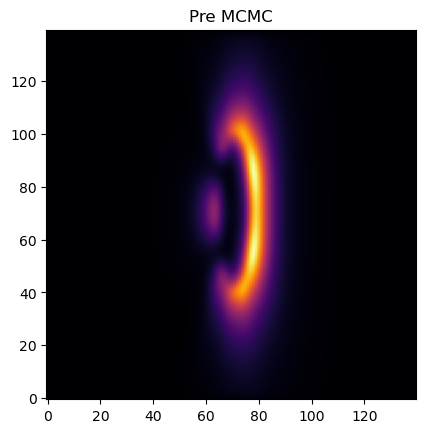

In [13]:
plt.imshow(img, origin='lower', cmap='inferno')
plt.title("Pre MCMC")

### Plotting MCMC Results

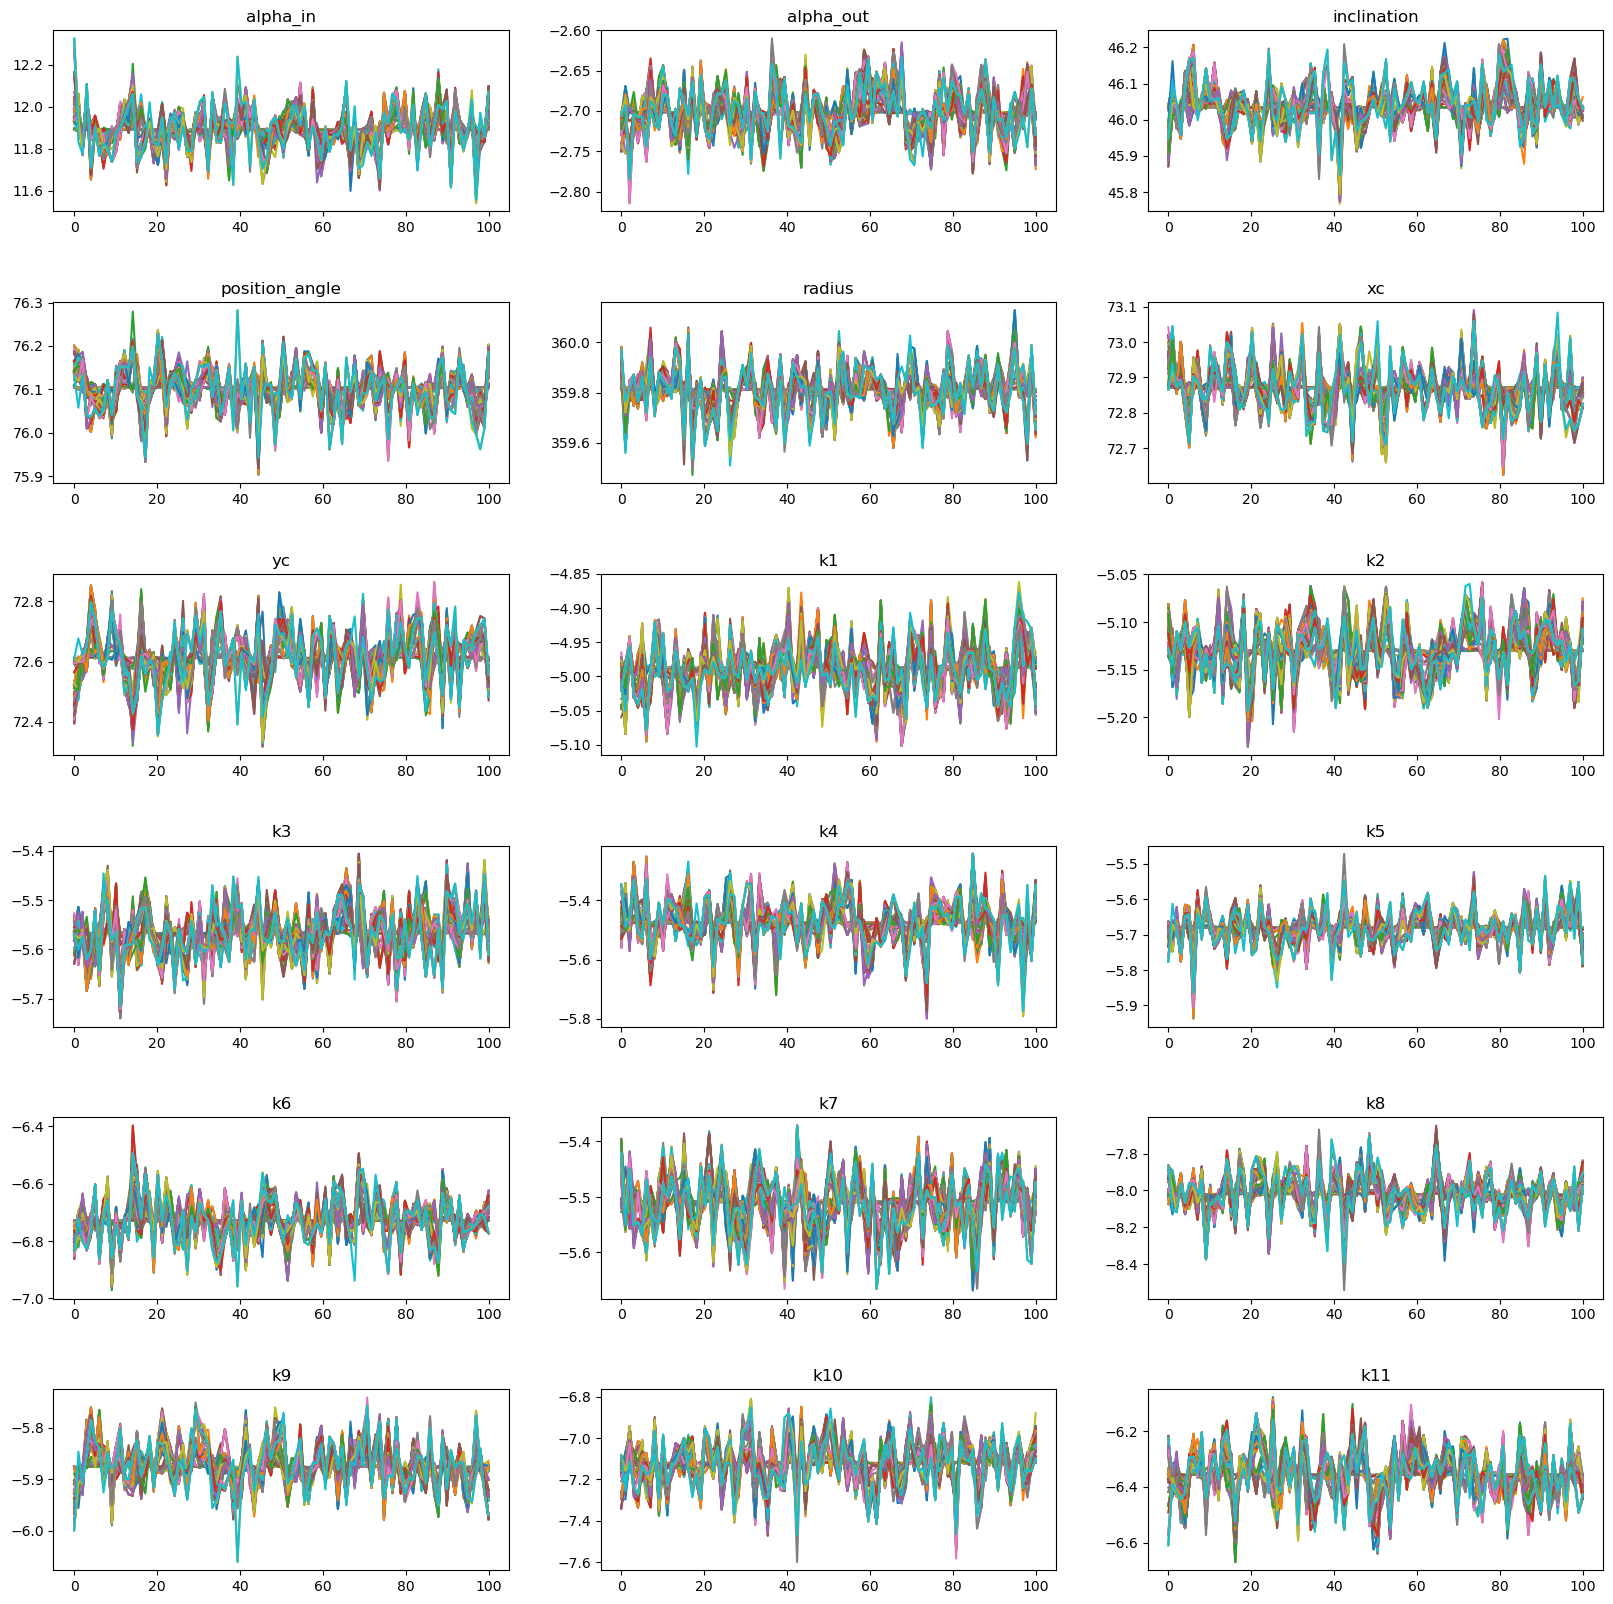

In [14]:
labels = ['alpha_in', 'alpha_out', 'inclination', 'position_angle', 'radius', 'xc', 'yc']
for i in range(0, int(row["Knots"])):
    labels.append('k'+str(i+1))
mc_model.plot_chains(labels)

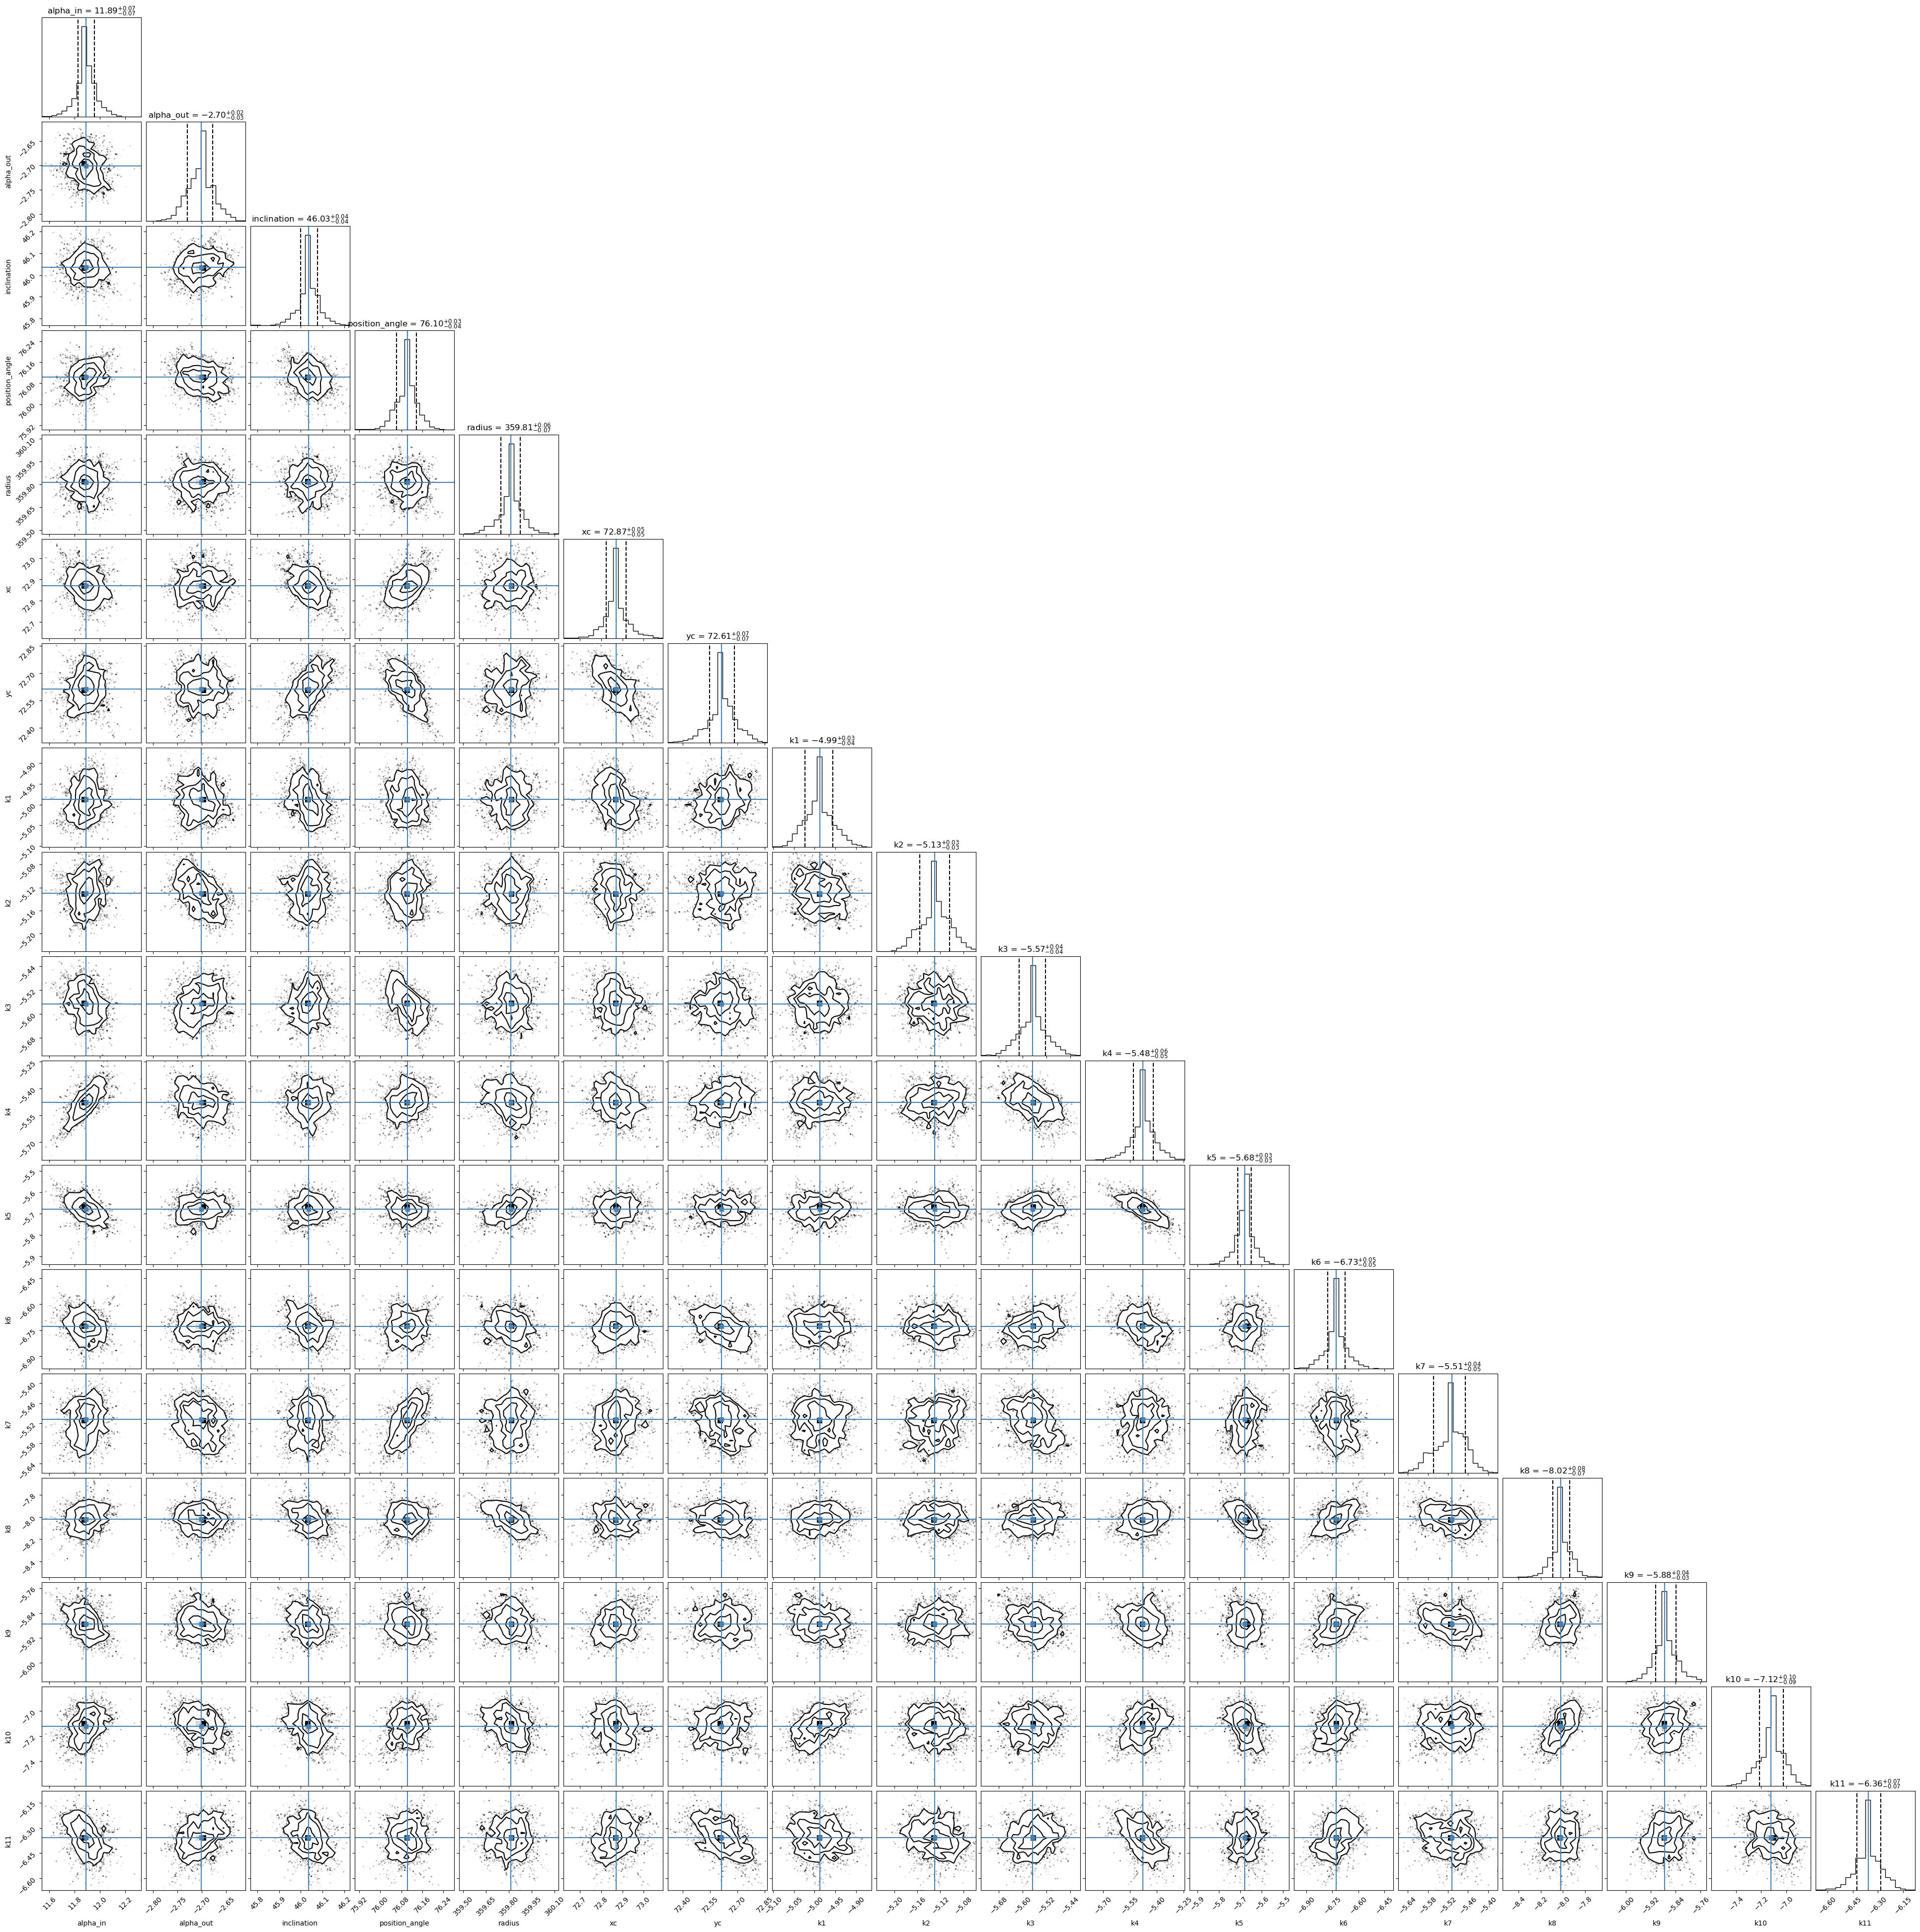

In [15]:
mc_model.show_corner_plot(labels, truths=mc_soln)